Image batch shape: torch.Size([20, 1, 288, 288, 36])


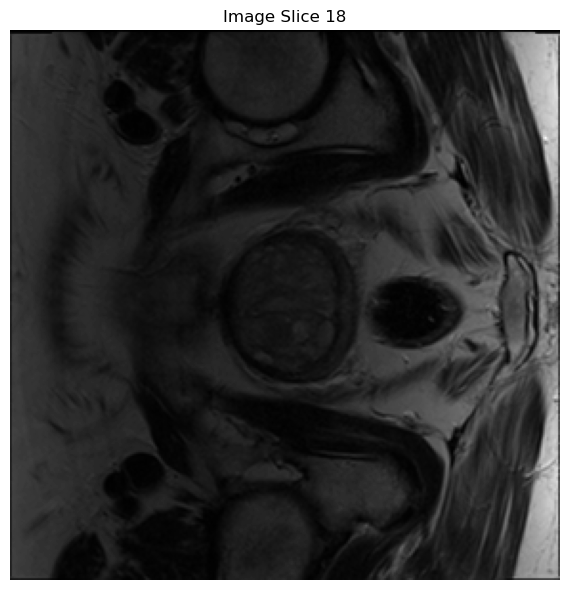

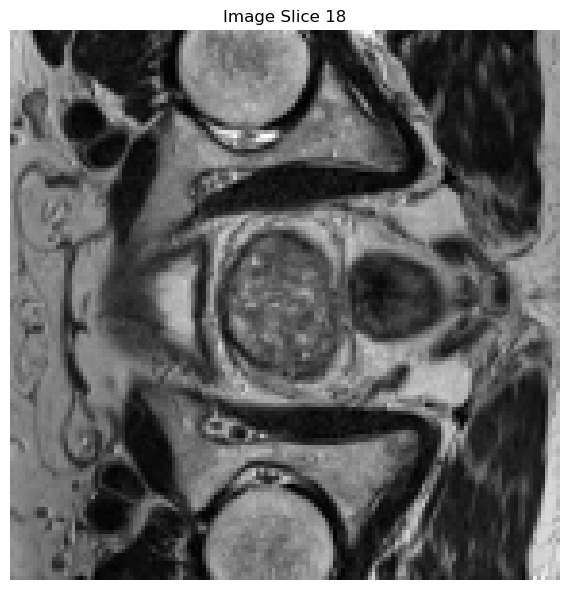

In [1]:
import os
import torch.nn as nn
import torch
import nibabel as nib
import numpy as np
from resize_function import resize_image_and_mask
from torch.utils.data import DataLoader, Dataset
from scipy.ndimage import zoom
from visualize_function import visualize_slice
from CNNv1 import CNNModel


# Define custom dataset classes
class NiftiDataset(Dataset):
    def __init__(self, img_paths, transform=None, target_shape=(288, 288, 36)):
        self.img_paths = img_paths
        self.transform = transform
        self.target_shape = target_shape

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # Load Image
        img = nib.load(self.img_paths[idx]).get_fdata()
        
        # Scaling and normalisation
        img = resize_image_and_mask(img, target_shape=self.target_shape)

        # Conversion to tensor
        return torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # 返回输入图像


  

# Creating Data path
train_img_paths = train_img_paths = [f"data/002{str(i).zfill(3)}_img.nii" for i in range(0, 40)]

test_img_path = [f"data/002089_img.nii"]

# Creating a Data Set
train_dataset = NiftiDataset(train_img_paths)
test_dataset = NiftiDataset(test_img_path)

# Creating a DataLoader
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Check that the data is loaded correctly

for imgs in train_loader:
    print("Image batch shape:", imgs.shape)  # should be (batch_size, 1, 288, 288, 36)
    break
# Example usage
# Select the first image and mask from the training set
for imgs in train_loader:
    # Extract only the first batch
    image_to_visualize = imgs[0].squeeze(0).numpy()  # Remove the batch and channel dimensions
    
    break
#visualize_slice(image_to_visualize,18)

for imgs in train_loader:
    # The shape of the imgs is (batch_size,288, 288, 36)
    
    
    # Downsample each image in the x-direction
    sampled_imgs = imgs[:,:, 3::2, 3::2, :]  # 取每8行，形状变为 (batch_size, 36, 288, 36)
    
    
    
    
    break

#print("undersampled image shape:", sampled_imgs.shape)  
#print("the first sampled_imgs",sampled_imgs[0].shape)    


#image_to_visualize = sampled_imgs[0].squeeze(0).numpy() 
    

visualize_slice(image_to_visualize,18)

visualize_slice(sampled_imgs[0].squeeze(0).numpy(),18)

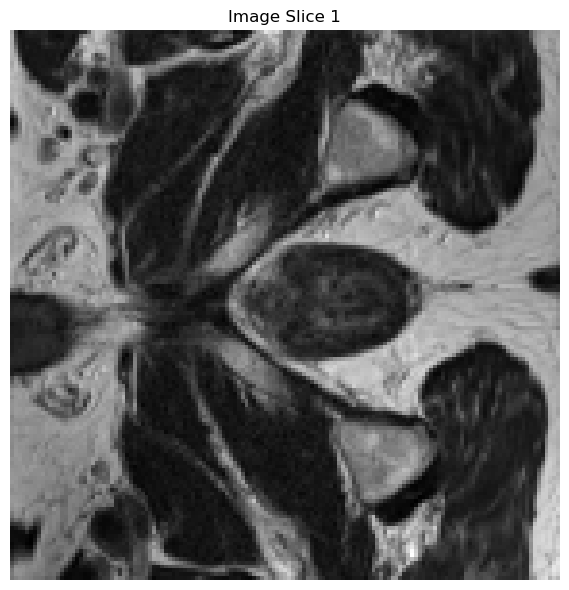

In [2]:
visualize_slice(sampled_imgs[0].squeeze(0).numpy(),1)

In [2]:


# Initialising models and configurations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs=15


# training cycle
for epoch in range(epochs):
    model.train()
    for imgs in train_loader:
        inputs=imgs[:,:, 3::8, :, :]
        inputs, imgs = inputs.to(device), imgs.to(device)

        # forward propagation
        outputs = model(inputs)

        # Calculation of losses
        loss = criterion(outputs, imgs)

        # Backpropagation and Optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")



Epoch 1/15, Loss: 0.05147553235292435
Epoch 2/15, Loss: 0.02289823815226555
Epoch 3/15, Loss: 0.017309896647930145
Epoch 4/15, Loss: 0.019652172923088074
Epoch 5/15, Loss: 0.027116598561406136
Epoch 6/15, Loss: 0.0183100663125515
Epoch 7/15, Loss: 0.01739475689828396
Epoch 8/15, Loss: 0.01147793885320425
Epoch 9/15, Loss: 0.009834670461714268
Epoch 10/15, Loss: 0.009604129008948803
Epoch 11/15, Loss: 0.009683691896498203
Epoch 12/15, Loss: 0.007519942708313465
Epoch 13/15, Loss: 0.008213589899241924
Epoch 14/15, Loss: 0.0069198752753436565
Epoch 15/15, Loss: 0.006781687028706074


FileNotFoundError: No such file or no access: '002089_img.nii'

In [5]:
model_path = "trained_model.pth"

torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to trained_model.pth


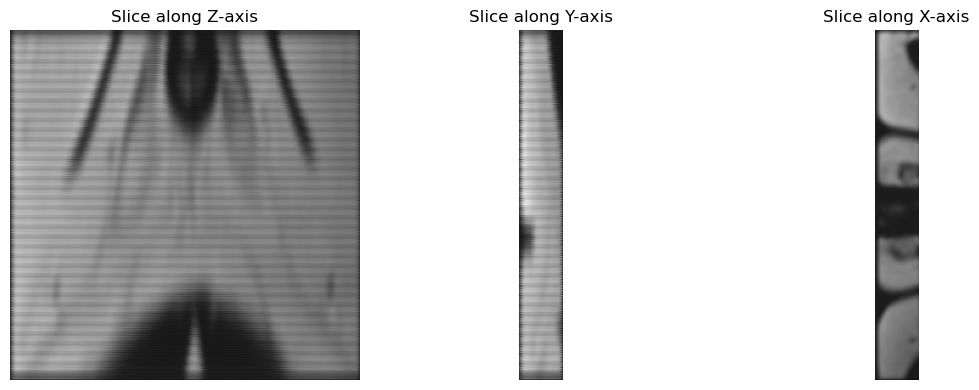

Final output shape: torch.Size([1, 1, 288, 288, 288])
Final tensor shape for saving: (288, 288, 288)
NIfTI file saved to output_image.nii


In [12]:
import matplotlib.pyplot as plt
model.eval()  # Set to evaluation mode

# Test Set Input Shape (batch_size, 288, 288, 36)
test_img = next(iter(test_loader)).to(device)  # Load test data
test_img = test_img.permute(0,1, 4, 2, 3)  # transpose to (batch_size, 36, 288, 288)

# Split into eight 36*288*36 tensors.
split_imgs = torch.split(test_img, split_size_or_sections=36, dim=-1)

outputs = []
for sub_img in split_imgs:
    output = model(sub_img)  # output (batch_size, 288, 288, 36)
    outputs.append(output)

plt.figure(figsize=(12, 4))


plt.subplot(1, 3, 1)
plt.imshow(outputs[0].squeeze().detach().cpu().numpy()[:, :, 18], cmap='gray', vmin=0, vmax=1)
plt.title("Slice along Z-axis")
plt.axis('off')


plt.subplot(1, 3, 2)
plt.imshow(outputs[0].squeeze().detach().cpu().numpy()[:, 18, :], cmap='gray', vmin=0, vmax=1)
plt.title("Slice along Y-axis")
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(outputs[0].squeeze().detach().cpu().numpy()[18, :, :], cmap='gray', vmin=0, vmax=1)
plt.title("Slice along X-axis")
plt.axis('off')

plt.tight_layout()
plt.show()
# Stitched to a full 288*288*288 sheet.
final_output = torch.cat(outputs, dim=-1)  # (batch_size, 288, 288, 288)

print("Final output shape:", final_output.shape)
final_output = final_output.cpu()

for imgs in final_output:
    
    image_to_visualize = imgs[0].squeeze(0).detach().numpy()  # Separate gradients and convert to NumPy
    break

final_output=final_output.permute(0,1,3,4,2)
#visualize_slice(image_to_visualize, 144)


final_output = final_output.squeeze().detach().cpu().numpy()  # Move to CPU, remove batch and channel dimensions
final_output=final_output[:,::-1, :,]
final_output = final_output.astype(np.float32)
#final_output = (final_output / final_output.max() * 255).astype(np.uint8)
# Check the shape
print("Final tensor shape for saving:", final_output.shape)  # should be (288, 288, 288)

# Creating affine matrices
affine = np.eye(4)

# Creating NIfTI Image Objects
nifti_img = nib.Nifti1Image(final_output, affine)

# Save as .nii file
output_path = "output_image.nii"
nib.save(nifti_img, output_path)

print(f"NIfTI file saved to {output_path}")